<a href="https://colab.research.google.com/github/JiseokSeo/Toy_Projects/blob/main/classification_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# kaggle API로 데이터를 다운로드합니다.
# kaggle token을 업로드해야합니다 -> 발급받아야함

from google.colab import files
kaggle_token = files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# data 디렉토리 생성
!mkdir /content/data

# 캐글 데이터 다운로드
!kaggle competitions download -c rsna-pneumonia-detection-challenge

# 다운로드 받은 케글 데이터를 data 디렉토리로 이동
!mv rsna-pneumonia-detection-challenge.zip /content/data

# 캐글 데이터를 data 디렉토리에 압축풀기
!unzip -q /content/data/rsna-pneumonia-detection-challenge.zip -d /content/data

100% 3.66G/3.66G [03:04<00:00, 25.1MB/s]
100% 3.66G/3.66G [03:04<00:00, 21.3MB/s]


In [4]:
!mkdir /content/labels
!mkdir /content/labels/train
!mkdir /content/labels/test

!unzip -q /content/drive/MyDrive/train_label.zip -d /content/labels/train
!unzip -q /content/drive/MyDrive/test_label.zip -d /content/labels/test

In [5]:
!mkdir /content/images
!mkdir /content/images/train
!mkdir /content/images/test

!unzip -q /content/drive/MyDrive/P_images.zip -d /content/images/train
!unzip -q /content/drive/MyDrive/P_images_test.zip -d /content/images/test

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import glob
from tqdm import tqdm
import zipfile
from sklearn.model_selection import train_test_split
import yaml
import torch
import shutil
import random
import math
from tqdm import tqdm
import csv
import albumentations as A
from albumentations import Compose, CLAHE
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import LabelEncoder

In [7]:
train = pd.read_csv('/content/data/stage_2_detailed_class_info.csv')
train['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [8]:
train['class'] = train['class'].map({'Normal':0,
                                     'No Lung Opacity / Not Normal':1,
                                     'Lung Opacity':2})

In [9]:
image_root = '/content/images/train'
label_root = '/content/labels/train/train_label'
train['image_path'] = train['patientId'].apply(lambda x: os.path.join(image_root, x + '.png'))
train['bbox_path'] = train['patientId'].apply(lambda x: os.path.join(label_root, x + '.txt'))
train

,patientId,class,image_path,bbox_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,/content/images/train/0004cfab-14fd-4e49-80ba-...,/content/labels/train/train_label/0004cfab-14f...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,1,/content/images/train/00313ee0-9eaa-42f4-b0ab-...,/content/labels/train/train_label/00313ee0-9ea...
2,00322d4d-1c29-4943-afc9-b6754be640eb,1,/content/images/train/00322d4d-1c29-4943-afc9-...,/content/labels/train/train_label/00322d4d-1c2...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,/content/images/train/003d8fa0-6bf1-40ed-b54c-...,/content/labels/train/train_label/003d8fa0-6bf...
4,00436515-870c-4b36-a041-de91049b9ab4,2,/content/images/train/00436515-870c-4b36-a041-...,/content/labels/train/train_label/00436515-870...
...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,2,/content/images/train/c1ec14ff-f6d7-4b38-b0cb-...,/content/labels/train/train_label/c1ec14ff-f6d...
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0,/content/images/train/c1edf42b-5958-47ff-a1e7-...,/content/labels/train/train_label/c1edf42b-595...
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0,/content/images/train/c1f6b555-2eb1-4231-98f6-...,/content/labels/train/train_label/c1f6b555-2eb...
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,2,/content/images/train/c1f7889a-9ea9-4acb-b64c-...,/content/labels/train/train_label/c1f7889a-9ea...


In [10]:
len(os.listdir('/content/data/stage_2_train_images'))

26684

In [11]:
train = train.drop_duplicates().reset_index(drop=True)
len(train)

26684

In [92]:
# 바운딩박스 내 이미지의 평균, 표준편차를 구함

import os
import cv2
import numpy as np

def compute_mean_std(image_paths, bbox_txt_paths, is_crop=False):
    assert len(image_paths) == len(bbox_txt_paths), "The number of image files and bbox files should be the same."

    means, stds = [], []
    for img_path, bbox_txt_path in zip(image_paths, bbox_txt_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =  A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), p=1)(image=img)['image']

        height, width, _ = img.shape

        if is_crop or os.path.isfile(bbox_txt_path) == False:
          with open(bbox_txt_path, 'r') as f:
              bboxes = f.readlines()

          for bbox in bboxes:
              _, x_center, y_center, w, h = map(float, bbox.strip().split())
              x1 = int((x_center - w/2) * width)
              y1 = int((y_center - h/2) * height)
              x2 = int((x_center + w/2) * width)
              y2 = int((y_center + h/2) * height)
              cropped_img = img[y1:y2, x1:x2]
              cropped_img = cropped_img / np.max(cropped_img)

              means.append(np.mean(cropped_img, axis=(0, 1)))
              stds.append(np.std(cropped_img, axis=(0, 1)))

        else:
          img = img / np.max(img)
          means.append(np.mean(img, axis=(0, 1)))
          stds.append(np.std(img, axis=(0, 1)))



    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std

In [93]:
sample_df = train.sample(200, random_state=42)
image_paths = sample_df['image_path'].tolist()
bbox_txt_paths = sample_df['bbox_path'].tolist()

print('crop=yes', compute_mean_std(image_paths, bbox_txt_paths, is_crop=True))
print('crop=no', compute_mean_std(image_paths, bbox_txt_paths, is_crop=False))

crop=yes (array([0.59208397, 0.59218266, 0.59201715]), array([0.20120514, 0.20118768, 0.20119067]))
crop=no (array([0.51610086, 0.51621241, 0.51606358]), array([0.23463445, 0.23457944, 0.23459176]))


In [12]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import densenet121
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 모델링 

In [14]:
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNetClassifier, self).__init__()
        self.model = densenet121(pretrained=True)
        
        # 기존 DenseNet121의 출력 레이어를 수정하여 3개의 클래스로 분류할 수 있도록 함
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

### 데이터세트 


In [15]:
class SampleDataset(Dataset):
  def __init__(self, df, is_crop=False, is_transform=False, transformer=None):
    self.df = df
    self.is_crop = is_crop
    self.is_transform = is_transform
    self.transformer = transformer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = self.df['image_path'][index]
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    target = self.df['class'][index]

    if self.is_crop:
      bbox_path = self.df['bbox_path'][index]

      if os.path.isfile(bbox_path):
        with open(bbox_path, 'r') as f:
          cls, x_c, y_c, w, h = list(map(float, f.read().split()))
          x1 = int(round(((x_c - w/2) * 1024), 0))
          y1 = int(round(((y_c - h/2) * 1024), 0))
          x2 = int(round(((x_c + w/2) * 1024), 0))
          y2 = int(round(((y_c + h/2) * 1024), 0))
      else:
        x1, y1, x2, y2 = 0, 0, 1023, 1023

      ROI = image[y1:y2, x1:x2]

    else:
      ROI = image

    # if self.is_transform and self.transformer != None:
    #   ROI = self.transformer(image=ROI)['image']
    # else:
    #   transformer_test = A.Compose([ToTensorV2()])
    #   ROI = transformer_test(image=ROI)['image']

    if len(ROI.shape) == 2:
      ROI = np.concatenate([ROI, ROI, ROI], axis=0)
    
    return {'image':ROI,
            'target':target}

In [16]:
# 데이터세트 검증
sample_train = train.iloc[0:10]
sample_dataset = SampleDataset(sample_train, is_crop=True, is_transform=False)

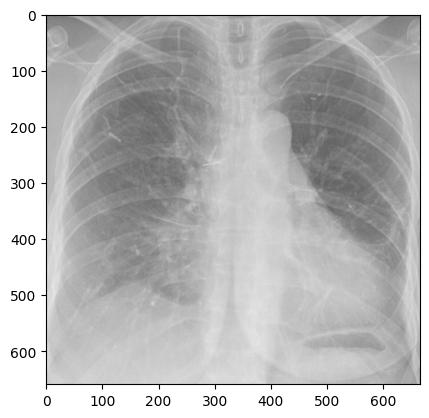

In [17]:
plt.imshow(sample_dataset[8]['image'])

# 크롭 기능이 잘 작동함을 확인할 수 있다

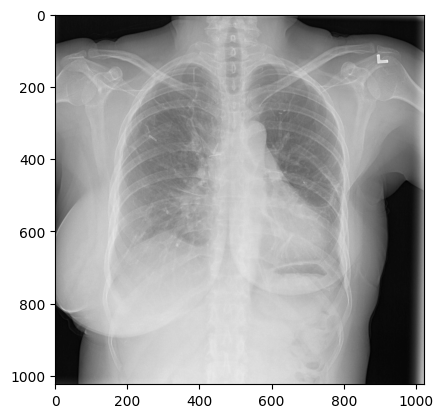

In [18]:
sample_dataset2 = SampleDataset(sample_train, is_crop=False, is_transform=False)
plt.imshow(sample_dataset2[8]['image'])

# 크롭이 안됨을 확인할 수 있다 

### 이제 시각화 필요 없으니 텐서로... 

In [20]:
class Dataset(Dataset):
  def __init__(self, df, is_crop=False, is_transform=False, transformer=None):
    self.df = df
    self.is_crop = is_crop
    self.is_transform = is_transform
    self.transformer = transformer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = self.df['image_path'][index]
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    target = self.df['class'][index]

    if self.is_crop:
      bbox_path = self.df['bbox_path'][index]

      if os.path.isfile(bbox_path):
        with open(bbox_path, 'r') as f:
          cls, x_c, y_c, w, h = list(map(float, f.read().split()))
          x1 = int(round(((x_c - w/2) * 1024), 0))
          y1 = int(round(((y_c - h/2) * 1024), 0))
          x2 = int(round(((x_c + w/2) * 1024), 0))
          y2 = int(round(((y_c + h/2) * 1024), 0))
      else:
        x1, y1, x2, y2 = 0, 0, 1023, 1023

      ROI = image[y1:y2, x1:x2]

    else:
      ROI = image

    if self.is_transform and self.transformer != None:
      ROI = self.transformer(image=ROI)['image']
    else:
      transformer_test = A.Compose([ToTensorV2()])
      ROI = transformer_test(image=ROI)['image']

    if len(ROI.shape) == 2:
      ROI = np.concatenate([ROI, ROI, ROI], axis=0)

    ROI = ROI.float()
    
    return {'image':ROI,
            'target':target}

## 훈련

In [21]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# 훈련, 검증, 평가 데이터 분리
train_df, test_df = train_test_split(train, test_size=0.15, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [24]:
len(train_df), len(valid_df), len(test_df)

(18144, 4537, 4003)

### 훈련1. 크롭X 전처리X : 베이스라인  

In [19]:
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

In [136]:
train_dataset_baseline = Dataset(train_df, is_crop=False, is_transform=True, transformer=transform)
valid_dataset_baseline = Dataset(valid_df, is_crop=False, is_transform=True, transformer=transform)

train_dataloader_baseline = DataLoader(train_dataset_baseline, batch_size=16, shuffle=True)
valid_dataloader_baseline = DataLoader(valid_dataset_baseline, batch_size=16, shuffle=False)

In [137]:
model = DenseNetClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [138]:
num_epochs = 50
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')
train_losses_baseline = []
val_losses_baseline = []
train_accs_baseline = []
val_accs_baseline = []

In [139]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data in tqdm(train_dataloader_baseline):
        inputs = data['image'].to(device)
        labels = data['target'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset_baseline)
    epoch_acc = running_corrects.double() / len(train_dataset_baseline)
    train_losses_baseline.append(epoch_loss)
    train_accs_baseline.append(epoch_acc)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data in tqdm(valid_dataloader_baseline):
            inputs = data['image'].to(device)
            labels = data['target'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_dataset_baseline)
        epoch_acc = running_corrects.double() / len(valid_dataset_baseline)
        val_losses_baseline.append(epoch_loss)
        val_accs_baseline.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            early_stopping_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'/content/drive/MyDrive/baseline/best_{epoch}_epochs.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print('Early stopping')
                model.load_state_dict(best_model_wts)
                break


Epoch 1/50
----------


100%|██████████| 1134/1134 [07:13<00:00,  2.62it/s]


Train Loss: 0.7909 Acc: 0.6252


100%|██████████| 284/284 [01:20<00:00,  3.52it/s]


Val Loss: 0.7184 Acc: 0.6637
Epoch 2/50
----------


100%|██████████| 1134/1134 [07:35<00:00,  2.49it/s]


Train Loss: 0.7195 Acc: 0.6689


100%|██████████| 284/284 [01:29<00:00,  3.19it/s]


Val Loss: 0.7905 Acc: 0.6652
Epoch 3/50
----------


100%|██████████| 1134/1134 [07:39<00:00,  2.47it/s]


Train Loss: 0.6937 Acc: 0.6836


100%|██████████| 284/284 [01:20<00:00,  3.51it/s]


Val Loss: 0.6421 Acc: 0.7152
Epoch 4/50
----------


100%|██████████| 1134/1134 [07:09<00:00,  2.64it/s]


Train Loss: 0.6758 Acc: 0.6958


100%|██████████| 284/284 [01:20<00:00,  3.54it/s]


Val Loss: 0.6964 Acc: 0.6846
Epoch 5/50
----------


100%|██████████| 1134/1134 [07:09<00:00,  2.64it/s]


Train Loss: 0.6539 Acc: 0.7046


100%|██████████| 284/284 [01:20<00:00,  3.52it/s]


Val Loss: 0.6493 Acc: 0.7064
Epoch 6/50
----------


100%|██████████| 1134/1134 [07:11<00:00,  2.63it/s]


Train Loss: 0.6435 Acc: 0.7103


100%|██████████| 284/284 [01:20<00:00,  3.55it/s]


Val Loss: 0.6942 Acc: 0.6934
Epoch 7/50
----------


100%|██████████| 1134/1134 [07:08<00:00,  2.65it/s]


Train Loss: 0.6316 Acc: 0.7157


100%|██████████| 284/284 [01:20<00:00,  3.53it/s]


Val Loss: 0.6358 Acc: 0.7097
Epoch 8/50
----------


100%|██████████| 1134/1134 [07:08<00:00,  2.65it/s]


Train Loss: 0.6140 Acc: 0.7256


100%|██████████| 284/284 [01:19<00:00,  3.55it/s]


Val Loss: 0.6417 Acc: 0.7033
Epoch 9/50
----------


100%|██████████| 1134/1134 [07:08<00:00,  2.65it/s]


Train Loss: 0.5936 Acc: 0.7352


100%|██████████| 284/284 [01:19<00:00,  3.56it/s]


Val Loss: 0.6389 Acc: 0.7062
Epoch 10/50
----------


100%|██████████| 1134/1134 [07:08<00:00,  2.65it/s]


Train Loss: 0.5747 Acc: 0.7469


100%|██████████| 284/284 [01:19<00:00,  3.55it/s]


Val Loss: 0.6647 Acc: 0.6916
Epoch 11/50
----------


100%|██████████| 1134/1134 [07:07<00:00,  2.65it/s]


Train Loss: 0.5585 Acc: 0.7563


100%|██████████| 284/284 [01:20<00:00,  3.54it/s]


Val Loss: 0.6291 Acc: 0.7207
Epoch 12/50
----------


100%|██████████| 1134/1134 [07:06<00:00,  2.66it/s]


Train Loss: 0.5302 Acc: 0.7703


100%|██████████| 284/284 [01:19<00:00,  3.57it/s]


Val Loss: 0.6513 Acc: 0.7150
Epoch 13/50
----------


100%|██████████| 1134/1134 [07:05<00:00,  2.66it/s]


Train Loss: 0.5075 Acc: 0.7785


100%|██████████| 284/284 [01:19<00:00,  3.57it/s]


Val Loss: 0.6627 Acc: 0.7148
Epoch 14/50
----------


100%|██████████| 1134/1134 [07:06<00:00,  2.66it/s]


Train Loss: 0.4712 Acc: 0.7955


100%|██████████| 284/284 [01:20<00:00,  3.54it/s]


Val Loss: 0.6606 Acc: 0.7146
Epoch 15/50
----------


100%|██████████| 1134/1134 [07:05<00:00,  2.66it/s]


Train Loss: 0.4347 Acc: 0.8150


100%|██████████| 284/284 [01:19<00:00,  3.59it/s]


Val Loss: 0.6855 Acc: 0.7221
Epoch 16/50
----------


100%|██████████| 1134/1134 [07:04<00:00,  2.67it/s]


Train Loss: 0.3972 Acc: 0.8319


100%|██████████| 284/284 [01:19<00:00,  3.57it/s]

Val Loss: 0.7420 Acc: 0.7024
Early stopping


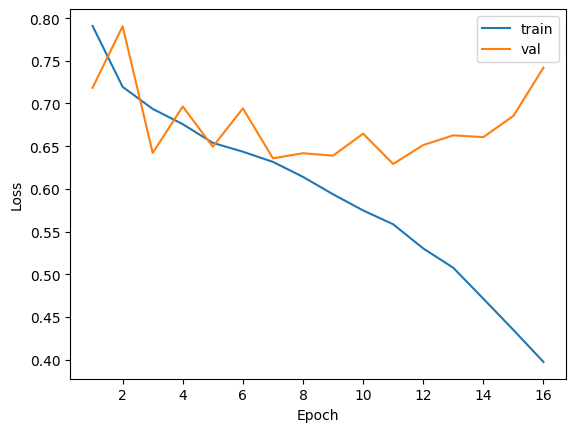

In [140]:
plt.plot(range(1, len(train_losses_baseline)+1), train_losses_baseline, label='train')
plt.plot(range(1, len(val_losses_baseline)+1), val_losses_baseline, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Original')
plt.legend()
plt.show()

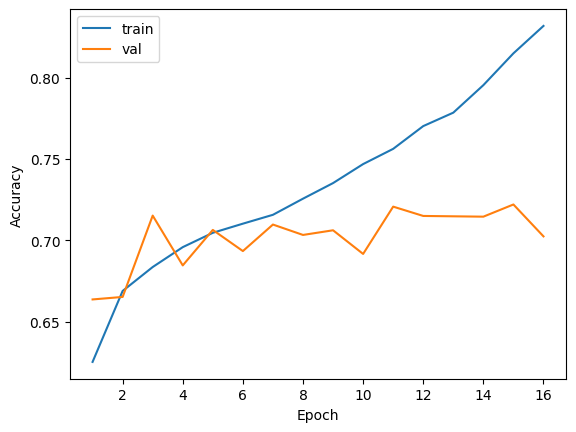

In [141]:
plt.plot(range(1, len(train_accs_baseline)+1), [n.cpu() for n in train_accs_baseline], label='train')
plt.plot(range(1, len(val_accs_baseline)+1), [n.cpu() for n in val_accs_baseline], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Original')
plt.legend()
plt.show()

### 훈련2. 크롭O 전처리X 커스텀모델1  

In [142]:
train_dataset_crop = Dataset(train_df, is_crop=True, is_transform=True, transformer=transform)
valid_dataset_crop = Dataset(valid_df, is_crop=True, is_transform=True, transformer=transform)

train_dataloader_crop = DataLoader(train_dataset_crop, batch_size=16, shuffle=True)
valid_dataloader_crop = DataLoader(valid_dataset_crop, batch_size=16, shuffle=False)

In [143]:
model = DenseNetClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [144]:
num_epochs = 50
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')
train_losses_crop = []
val_losses_crop = []
train_accs_crop = []
val_accs_crop = []

In [145]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data in tqdm(train_dataloader_crop):
        inputs = data['image'].to(device)
        labels = data['target'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset_crop)
    epoch_acc = running_corrects.double() / len(train_dataset_crop)
    train_losses_crop.append(epoch_loss)
    train_accs_crop.append(epoch_acc)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data in tqdm(valid_dataloader_crop):
            inputs = data['image'].to(device)
            labels = data['target'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_dataset_crop)
        epoch_acc = running_corrects.double() / len(valid_dataset_crop)
        val_losses_crop.append(epoch_loss)
        val_accs_crop.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            early_stopping_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'/content/drive/MyDrive/crop_model/best_{epoch}_epochs.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print('Early stopping')
                model.load_state_dict(best_model_wts)
                break


Epoch 1/50
----------


100%|██████████| 1134/1134 [07:19<00:00,  2.58it/s]


Train Loss: 0.7744 Acc: 0.6384


100%|██████████| 284/284 [01:22<00:00,  3.44it/s]


Val Loss: 0.6985 Acc: 0.6705
Epoch 2/50
----------


100%|██████████| 1134/1134 [07:17<00:00,  2.59it/s]


Train Loss: 0.7106 Acc: 0.6764


100%|██████████| 284/284 [01:21<00:00,  3.47it/s]


Val Loss: 0.7222 Acc: 0.6879
Epoch 3/50
----------


100%|██████████| 1134/1134 [07:15<00:00,  2.60it/s]


Train Loss: 0.6904 Acc: 0.6885


100%|██████████| 284/284 [01:21<00:00,  3.47it/s]


Val Loss: 0.6330 Acc: 0.7141
Epoch 4/50
----------


100%|██████████| 1134/1134 [07:17<00:00,  2.59it/s]


Train Loss: 0.6683 Acc: 0.6975


100%|██████████| 284/284 [01:23<00:00,  3.40it/s]


Val Loss: 0.6756 Acc: 0.6932
Epoch 5/50
----------


100%|██████████| 1134/1134 [07:21<00:00,  2.57it/s]


Train Loss: 0.6515 Acc: 0.7083


100%|██████████| 284/284 [01:22<00:00,  3.46it/s]


Val Loss: 0.6514 Acc: 0.7117
Epoch 6/50
----------


100%|██████████| 1134/1134 [07:14<00:00,  2.61it/s]


Train Loss: 0.6353 Acc: 0.7137


100%|██████████| 284/284 [01:21<00:00,  3.49it/s]


Val Loss: 0.6375 Acc: 0.7168
Epoch 7/50
----------


100%|██████████| 1134/1134 [07:13<00:00,  2.61it/s]


Train Loss: 0.6213 Acc: 0.7206


100%|██████████| 284/284 [01:21<00:00,  3.48it/s]


Val Loss: 0.6409 Acc: 0.7172
Epoch 8/50
----------


100%|██████████| 1134/1134 [07:15<00:00,  2.60it/s]


Train Loss: 0.6091 Acc: 0.7307


100%|██████████| 284/284 [01:21<00:00,  3.48it/s]


Val Loss: 0.6282 Acc: 0.7218
Epoch 9/50
----------


100%|██████████| 1134/1134 [07:16<00:00,  2.60it/s]


Train Loss: 0.5952 Acc: 0.7350


100%|██████████| 284/284 [01:21<00:00,  3.47it/s]


Val Loss: 0.6642 Acc: 0.7022
Epoch 10/50
----------


100%|██████████| 1134/1134 [07:18<00:00,  2.59it/s]


Train Loss: 0.5769 Acc: 0.7477


100%|██████████| 284/284 [01:22<00:00,  3.44it/s]


Val Loss: 0.6139 Acc: 0.7300
Epoch 11/50
----------


100%|██████████| 1134/1134 [07:16<00:00,  2.60it/s]


Train Loss: 0.5591 Acc: 0.7504


100%|██████████| 284/284 [01:22<00:00,  3.43it/s]


Val Loss: 0.6432 Acc: 0.7155
Epoch 12/50
----------


100%|██████████| 1134/1134 [07:17<00:00,  2.59it/s]


Train Loss: 0.5331 Acc: 0.7674


100%|██████████| 284/284 [01:22<00:00,  3.45it/s]


Val Loss: 0.6157 Acc: 0.7311
Epoch 13/50
----------


100%|██████████| 1134/1134 [07:17<00:00,  2.59it/s]


Train Loss: 0.5127 Acc: 0.7781


100%|██████████| 284/284 [01:22<00:00,  3.43it/s]


Val Loss: 0.6439 Acc: 0.7192
Epoch 14/50
----------


100%|██████████| 1134/1134 [07:17<00:00,  2.59it/s]


Train Loss: 0.4816 Acc: 0.7924


100%|██████████| 284/284 [01:22<00:00,  3.44it/s]


Val Loss: 0.6542 Acc: 0.7097
Epoch 15/50
----------


100%|██████████| 1134/1134 [07:16<00:00,  2.60it/s]


Train Loss: 0.4383 Acc: 0.8145


100%|██████████| 284/284 [01:22<00:00,  3.44it/s]


Val Loss: 0.7494 Acc: 0.7051
Early stopping


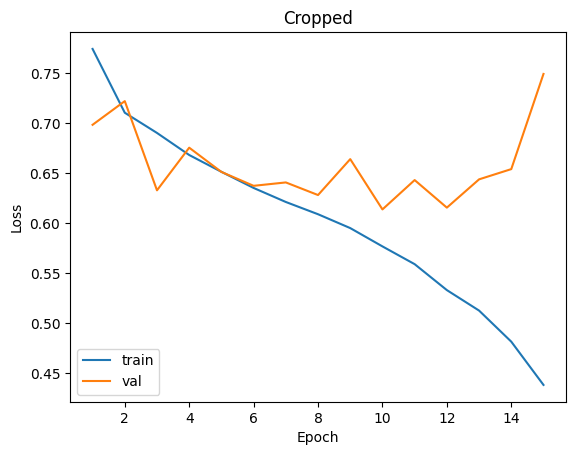

In [146]:
plt.plot(range(1, len(train_losses_crop)+1), train_losses_crop, label='train')
plt.plot(range(1, len(val_losses_crop)+1), val_losses_crop, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cropped')
plt.legend()
plt.show()

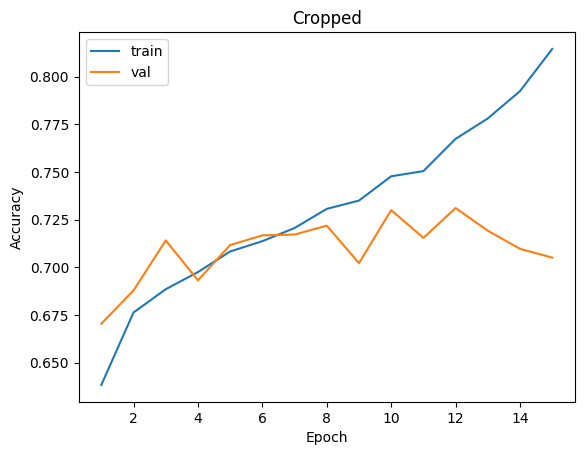

In [147]:
plt.plot(range(1, len(train_accs_crop)+1), [n.cpu() for n in train_accs_crop], label='train')
plt.plot(range(1, len(val_accs_crop)+1), [n.cpu() for n in val_accs_crop], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cropped')
plt.legend()
plt.show()

### 훈련3 크롭X 전처리O 커스텀모델2



In [182]:
def normalize_by_max(img):
    img = img / np.max(img)
    return img

crop_transformer = {'train':A.Compose([A.Lambda(image=normalize_by_max),
                                       A.Normalize(mean=(0.5947, 0.5947, 0.5947), std=(0.1904, 0.1904, 0.1904)),
                                       A.Resize(224, 224),
                                       A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), p=1.0),
                                       A.InvertImg(p=0.1),
                                       A.RandomRotate90(p=0.1),
                                       A.GaussianBlur(blur_limit=(5, 7), p=0.2),
                                       ToTensorV2()]),
                      'valid':A.Compose([A.Lambda(image=normalize_by_max),
                                         A.Normalize(mean=(0.5947, 0.5947, 0.5947), std=(0.1904, 0.1904, 0.1904)),
                                         A.Resize(224, 224),
                                         A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), p=1.0),
                                         ToTensorV2()])}

no_crop_transformer = {'train':A.Compose([A.Lambda(image=normalize_by_max),
                                         A.Normalize(mean=(0.5076, 0.5076, 0.5076), std=(0.2341, 0.2341, 0.2341)),
                                         A.Resize(224, 224),
                                         A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), p=1.0),
                                         A.InvertImg(p=0.1),
                                         A.RandomRotate90(p=0.1),
                                         A.GaussianBlur(blur_limit=(5, 7), p=0.2),
                                         ToTensorV2()]),
                      'valid':A.Compose([A.Lambda(image=normalize_by_max),
                                         A.Normalize(mean=(0.5076, 0.5076, 0.5076), std=(0.2341, 0.2341, 0.2341)),
                                         A.CLAHE(clip_limit=1.0, tile_grid_size=(8, 8), p=1.0),
                                         A.Resize(224, 224),
                                         ToTensorV2()])}                                    

In [171]:
train_dataset_pre = Dataset(train_df, is_crop=False, is_transform=True, transformer=no_crop_transformer['train'])
valid_dataset_pre = Dataset(valid_df, is_crop=False, is_transform=True, transformer=no_crop_transformer['valid'])

train_dataloader_pre = DataLoader(train_dataset_pre, batch_size=16, shuffle=True, num_workers=2)
valid_dataloader_pre = DataLoader(valid_dataset_pre, batch_size=16, shuffle=False, num_workers=2)

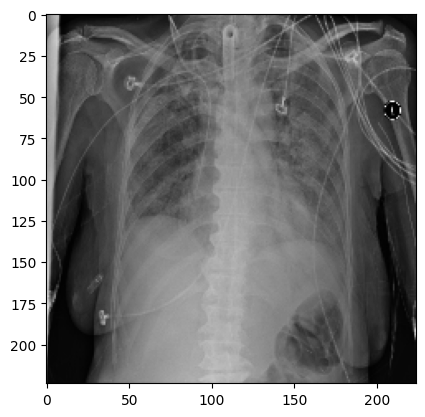

In [159]:
plt.imshow(train_dataset_pre[0]['image'][0], cmap='gray')
plt.show()

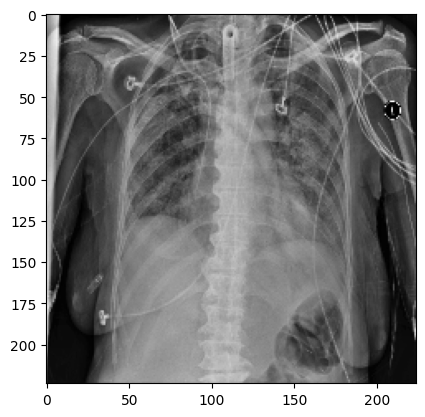

In [172]:
plt.imshow(train_dataset_pre[0]['image'][0], cmap='gray')
plt.show()

In [173]:
model = DenseNetClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [174]:
num_epochs = 50
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')
train_losses_pre = []
val_losses_pre = []
train_accs_pre = []
val_accs_pre = []

In [175]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data in tqdm(train_dataloader_pre):
        inputs = data['image'].to(device)
        labels = data['target'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset_pre)
    epoch_acc = running_corrects.double() / len(train_dataset_pre)
    train_losses_pre.append(epoch_loss)
    train_accs_pre.append(epoch_acc)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data in tqdm(valid_dataloader_pre):
            inputs = data['image'].to(device)
            labels = data['target'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_dataset_pre)
        epoch_acc = running_corrects.double() / len(valid_dataset_pre)
        val_losses_pre.append(epoch_loss)
        val_accs_pre.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            early_stopping_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'/content/drive/MyDrive/pre_model/best_{epoch}_epochs.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print('Early stopping')
                model.load_state_dict(best_model_wts)
                break

Epoch 1/50
----------


100%|██████████| 1134/1134 [20:06<00:00,  1.06s/it]


Train Loss: 0.9498 Acc: 0.5219


100%|██████████| 284/284 [04:48<00:00,  1.02s/it]


Val Loss: 6.5910 Acc: 0.2215
Epoch 2/50
----------


100%|██████████| 1134/1134 [20:04<00:00,  1.06s/it]


Train Loss: 0.8750 Acc: 0.5748


100%|██████████| 284/284 [04:49<00:00,  1.02s/it]


Val Loss: 1.0851 Acc: 0.4446
Epoch 3/50
----------


100%|██████████| 1134/1134 [19:53<00:00,  1.05s/it]


Train Loss: 0.8318 Acc: 0.5985


100%|██████████| 284/284 [04:50<00:00,  1.02s/it]


Val Loss: 1.1937 Acc: 0.4446
Epoch 4/50
----------


100%|██████████| 1134/1134 [19:43<00:00,  1.04s/it]


Train Loss: 0.8043 Acc: 0.6126


100%|██████████| 284/284 [04:40<00:00,  1.01it/s]


Val Loss: 1.1298 Acc: 0.3339
Epoch 5/50
----------


100%|██████████| 1134/1134 [20:00<00:00,  1.06s/it]


Train Loss: 0.7935 Acc: 0.6249


100%|██████████| 284/284 [04:47<00:00,  1.01s/it]


Val Loss: 1.2220 Acc: 0.3339
Epoch 6/50
----------


100%|██████████| 1134/1134 [18:56<00:00,  1.00s/it]


Train Loss: 0.7700 Acc: 0.6324


100%|██████████| 284/284 [04:33<00:00,  1.04it/s]


Val Loss: 5.0366 Acc: 0.4446
Epoch 7/50
----------


100%|██████████| 1134/1134 [19:01<00:00,  1.01s/it]


Train Loss: 0.7623 Acc: 0.6398


100%|██████████| 284/284 [04:34<00:00,  1.03it/s]

Val Loss: 1.7797 Acc: 0.2215
Early stopping


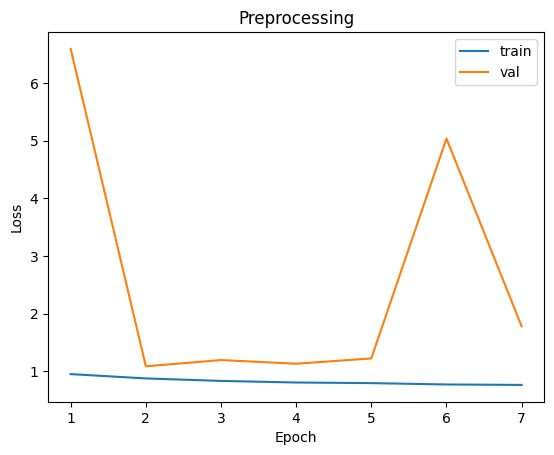

In [176]:
plt.plot(range(1, len(train_losses_pre)+1), train_losses_pre, label='train')
plt.plot(range(1, len(val_losses_pre)+1), val_losses_pre, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Preprocessing')
plt.legend()
plt.show()

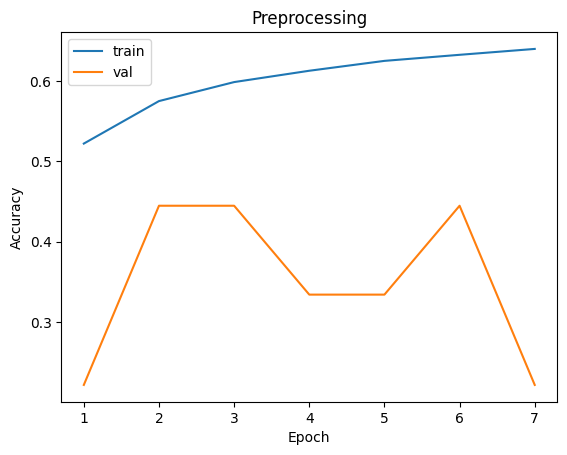

In [177]:
plt.plot(range(1, len(train_accs_pre)+1), [n.cpu() for n in train_accs_pre], label='train')
plt.plot(range(1, len(val_accs_pre)+1), [n.cpu() for n in val_accs_pre], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Preprocessing')
plt.legend()
plt.show()

### 훈련4 크롭O 전처리O 커스텀모델3

In [178]:
train_dataset_crop_pre = Dataset(train_df, is_crop=True, is_transform=True, transformer=crop_transformer['train'])
valid_dataset_crop_pre = Dataset(valid_df, is_crop=True, is_transform=True, transformer=crop_transformer['valid'])

train_dataloader_crop_pre = DataLoader(train_dataset_crop_pre, batch_size=16, shuffle=True, num_workers=2)
valid_dataloader_crop_pre = DataLoader(valid_dataset_crop_pre, batch_size=16, shuffle=False, num_workers=2)

In [179]:
model = DenseNetClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [180]:
num_epochs = 50
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')
train_losses_crop_pre = []
val_losses_crop_pre = []
train_accs_crop_pre = []
val_accs_crop_pre = []

In [181]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data in tqdm(train_dataloader_crop_pre):
        inputs = data['image'].to(device)
        labels = data['target'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset_crop_pre)
    epoch_acc = running_corrects.double() / len(train_dataset_crop_pre)
    train_losses_crop_pre.append(epoch_loss)
    train_accs_crop_pre.append(epoch_acc)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data in tqdm(valid_dataloader_crop_pre):
            inputs = data['image'].to(device)
            labels = data['target'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_dataset_crop_pre)
        epoch_acc = running_corrects.double() / len(valid_dataset_crop_pre)
        val_losses_crop_pre.append(epoch_loss)
        val_accs_crop_pre.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            early_stopping_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'/content/drive/MyDrive/crop_pre_model/best_{epoch}_epochs.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print('Early stopping')
                model.load_state_dict(best_model_wts)
                break

Epoch 1/50
----------


100%|██████████| 1134/1134 [11:58<00:00,  1.58it/s]


Train Loss: 0.8840 Acc: 0.5704


100%|██████████| 284/284 [02:46<00:00,  1.70it/s]


Val Loss: 3.7221 Acc: 0.2215
Epoch 2/50
----------


100%|██████████| 1134/1134 [11:58<00:00,  1.58it/s]


Train Loss: 0.8080 Acc: 0.6181


100%|██████████| 284/284 [02:46<00:00,  1.71it/s]


Val Loss: 3.1119 Acc: 0.2215
Epoch 3/50
----------


  8%|▊         | 94/1134 [01:00<11:13,  1.54it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(range(1, len(train_losses_crop_pre)+1), train_losses_crop_pre, label='train')
plt.plot(range(1, len(val_losses_crop_pre)+1), val_losses_crop_pre, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cropped_and_Preprocessed')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, len(train_accs_crop_pre)+1), [n.cpu() for n in train_accs_crop_pre], label='train')
plt.plot(range(1, len(val_accs_crop_pre)+1), [n.cpu() for n in val_accs_crop_pre], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cropped_and_Preprocessed')
plt.legend()
plt.show()